In [1]:
# std lib
from getpass import getpass

# 3rd party 
import numpy as np
from numpy.core.defchararray import startswith
import pylab as plt
import matplotlib
%matplotlib inline

import astropy
from astropy import units
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from matplotlib.patches import Ellipse, Circle

import matplotlib.pyplot as matplt
from astropy import units
from astropy.table import unique
from astropy import table
from astropy.table import Table
import os
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
from scipy.ndimage import gaussian_filter
import math
from scipy.interpolate import interp1d
from astropy import wcs
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from reproject.mosaicking import find_optimal_celestial_wcs
from scipy.optimize import curve_fit
import requests
from math import pi

# inmport SIA library and utilities for accessing FITS images and making three-color images
from pyvo.dal import sia
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

from dl import queryClient as qc, storeClient as sc, authClient as ac

# Quiet the Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [2]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

Enter user name: (+ENTER)  huangyuxin
Enter password: (+ENTER)  ·············


In [3]:
ac.whoAmI()

'yuxinhuang'

In [2]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr1"
svc_des_dr1 = sia.SIAService(DEF_ACCESS_URL)

In [3]:
FRB = '180924'
pos = '21h44m25.3s -40d54m00s'
c = SkyCoord(pos, frame="icrs")
RA = c.ra.degree
DEC = c.dec.degree
print(RA, DEC)

326.10541666666666 -40.9


In [4]:
dec_range = 1.1
ra_range = dec_range/np.cos(DEC/180*np.pi)
print(RA-ra_range, RA+ra_range)
print(DEC-dec_range, DEC+dec_range)

324.6501081381349 327.5607251951984
-42.0 -39.8


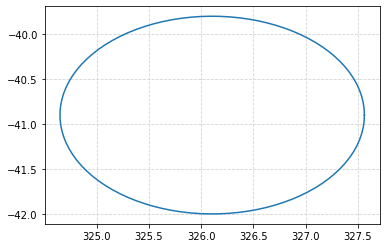

In [201]:
u=RA     #x-position of the center
v=DEC    #y-position of the center
a=ra_range     #radius on the x-axis
b=dec_range    #radius on the y-axis

t = np.linspace(0, 2*pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) )
plt.grid(color='lightgray',linestyle='--')
plt.show()

In [204]:
row_top = -40.0
row_bottom = -40.2

x_arr = u+a*np.cos(t)
y_arr = v+b*np.sin(t)
max(x_arr[np.where((y_arr<row_top)*(y_arr>row_bottom))])

327.2202476779721

In [77]:
ra_save = []
dec_save = []

hdu_arr=[]

### Loop from here

In [188]:
fov = 1.2
ra = ra_new
dec = dec_new
imgTable = svc_des_dr1.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

sel = (imgTable['proctype'].astype(str)=='Stack') & (imgTable['prodtype'].astype(str)=='image') & \
    (startswith(imgTable['obs_bandpass'].astype(str),'r'))
imgTable[sel]

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr1,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES2140-4206_r2601p01_r.fits.fz&extn=1&POS=324.986041563935,-42.1016892850956&SIZE=1.617346419734477,1.2",image/fits,165819,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES2140-4206_r2601p01_r.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES2140-4206_r2601p01_r.fits.fz&extn=1&POS=324.986041563935,-42.1016892850956&SIZE=1.617346419734477,1.2&preview=true",,,325.037,-42.1017,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,DES2140-4206,0,DES DR1,30,image,0,0,,630,,Stack,,556926.07856956,0


In [189]:
row = imgTable[sel][0]
url = row['access_url'] # get the download URL
#image = fits.getdata(download_file(url,cache=True,show_progress=False,timeout=120))
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header
wcs = WCS(hdr)
print(image.min(),image.max(),image.shape)

-77.341415 45739.22 (10000, 10000)


In [190]:
w = WCS(hdu.header)

pix_x = list(range(hdu.data.shape[0]))
pix_y = [0]*hdu.data.shape[0]
ralist0 = np.zeros(hdu.data.shape[0])
declist0 = np.zeros(hdu.data.shape[0])
sky = w.pixel_to_world(pix_x,pix_y)
ralist0 = sky.ra.deg
declist0 = sky.dec.deg

pix_x = [hdu.data.shape[0]]*hdu.data.shape[1]
pix_y = list(range(hdu.data.shape[1]))
ralist1 = np.zeros(hdu.data.shape[1])
declist1 = np.zeros(hdu.data.shape[1])
sky = w.pixel_to_world(pix_x,pix_y)
ralist1 = sky.ra.deg
declist1 = sky.dec.deg

pix_x = list(range(hdu.data.shape[0]))
pix_y = [hdu.data.shape[1]]*hdu.data.shape[0]
ralist2 = np.zeros(hdu.data.shape[0])
declist2 = np.zeros(hdu.data.shape[0])
sky = w.pixel_to_world(pix_x,pix_y)
ralist2 = sky.ra.deg[::-1]
declist2 = sky.dec.deg[::-1]

pix_x = [0]*hdu.data.shape[1]
pix_y = list(range(hdu.data.shape[1]))
ralist3 = np.zeros(hdu.data.shape[1])
declist3 = np.zeros(hdu.data.shape[1])
sky = w.pixel_to_world(pix_x,pix_y)
ralist3 = sky.ra.deg[::-1]
declist3 = sky.dec.deg[::-1]

ralist = np.hstack((ralist0, ralist1, ralist2, ralist3))
declist = np.hstack((declist0, declist1, declist2, declist3))

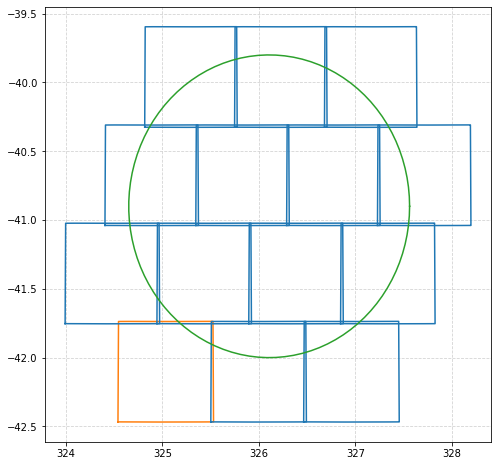

In [191]:
plt.figure(figsize=(8,8))

plt.plot(ralist, declist, c='#ff7f0e')

for i in range(len(ra_save)):
    plt.plot(ra_save[i], dec_save[i], c='#1f77b4')

t = np.linspace(0, 2*pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), c='#2ca02c' )
plt.grid(color='lightgray',linestyle='--')

plt.show()

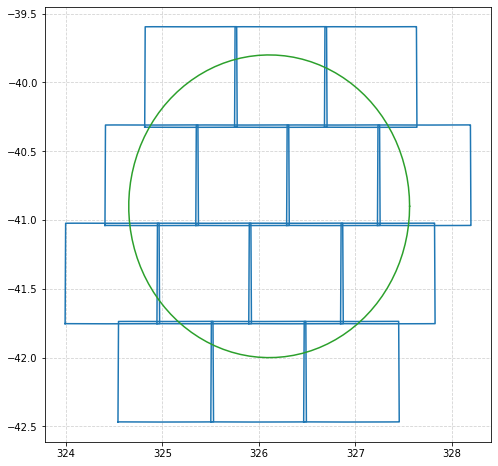

In [192]:
ra_save.insert(len(ra_save)+1,ralist)
dec_save.insert(len(dec_save)+1,declist)

plt.figure(figsize=(8,8))

for i in range(len(ra_save)):
    plt.plot(ra_save[i], dec_save[i], c='#1f77b4')

t = np.linspace(0, 2*pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), c='#2ca02c' )
plt.grid(color='lightgray',linestyle='--')

plt.show()

In [193]:
hdu_arr.insert(len(hdu_arr)+1,hdu)
hdu_arr

In [187]:
step = np.array([-2,0])

ra_cen = (w.pixel_to_world(0,0).ra.deg + w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).ra.deg) / 2
dec_cen = (w.pixel_to_world(0,0).dec.deg + w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg) / 2

ra_new = ra_cen + (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).ra.deg - w.pixel_to_world(0,0).ra.deg) * step[0]
dec_new = dec_cen + (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg) * step[1]

#### -- Loop end

In [40]:
dec_range = 1.1
ra_range = dec_range/np.cos(DEC/180*np.pi)
print(RA-ra_range, RA+ra_range)
print(DEC-dec_range, DEC+dec_range)

324.6501081381349 327.5607251951984
-42.0 -39.8


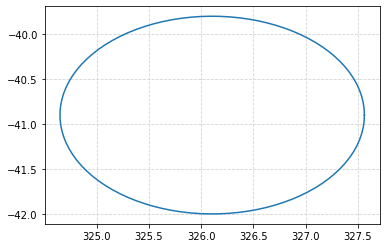

In [41]:
u=RA     #x-position of the center
v=DEC    #y-position of the center
a=ra_range     #radius on the x-axis
b=dec_range    #radius on the y-axis

t = np.linspace(0, 2*pi, 100)
x_arr = u+a*np.cos(t)
y_arr = v+b*np.sin(t)
plt.plot(x_arr, y_arr)
plt.grid(color='lightgray',linestyle='--')
plt.show()

In [42]:
ra_save = []
dec_save = []
ralist = []
declist = []

hdu_arr=[]

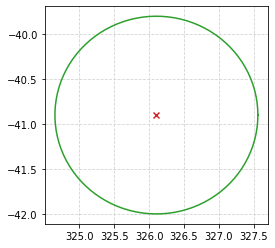

-127.35782 41517.914 (10000, 10000)


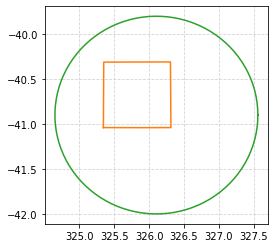

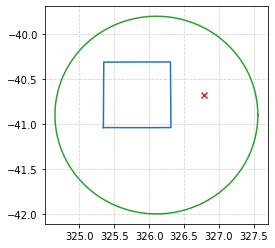

-38.965927 43374.65 (10000, 10000)


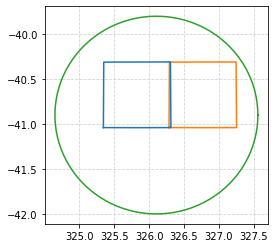

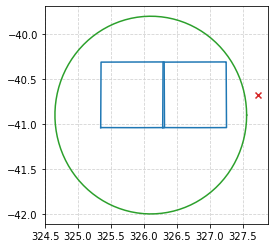

-48.957268 44932.21 (10000, 10000)


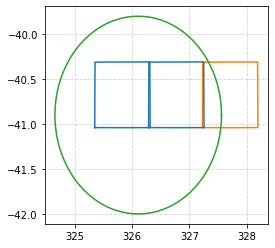

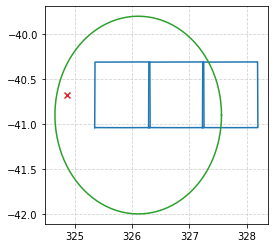

-34.703335 38025.88 (10000, 10000)


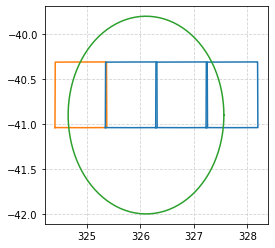

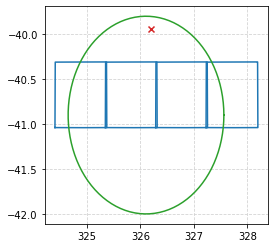

-90.2506 50888.285 (10000, 10000)


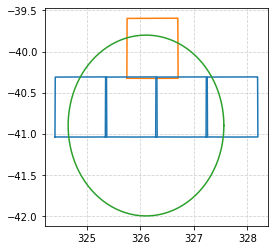

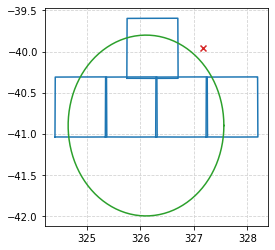

-98.27069 41992.82 (10000, 10000)


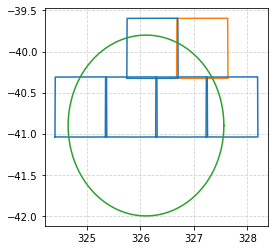

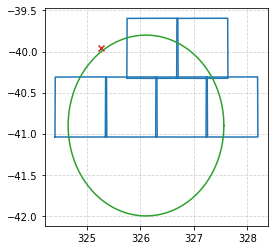

-96.47237 48148.56 (10000, 10000)


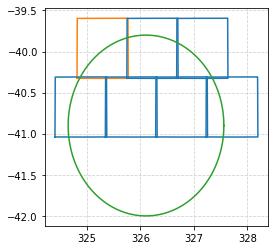

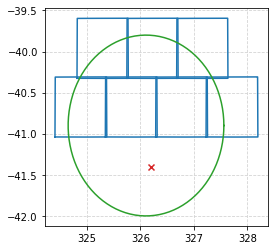

-37.02783 40409.17 (10000, 10000)


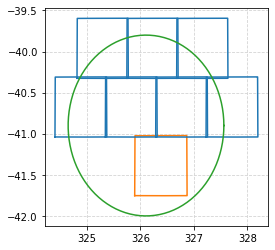

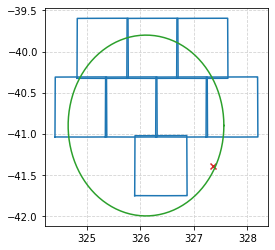

-38.01339 38812.367 (10000, 10000)


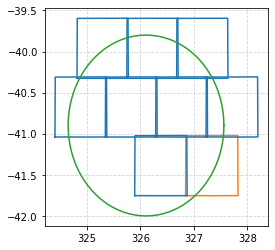

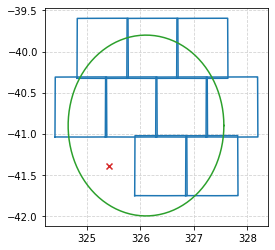

-54.45658 45579.383 (10000, 10000)


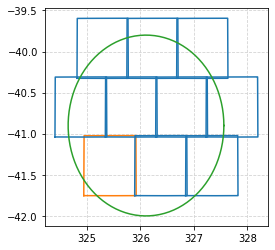

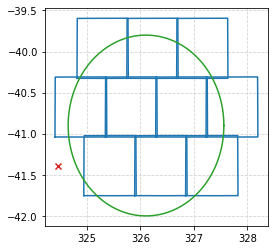

-36.776524 32136.252 (10000, 10000)


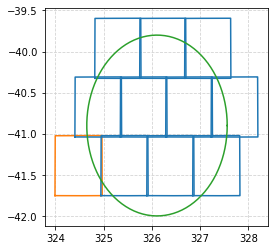

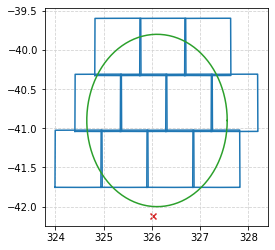

-43.108734 50485.176 (10000, 10000)


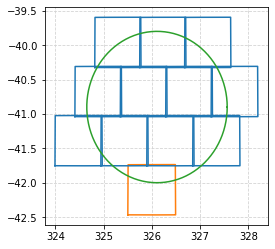

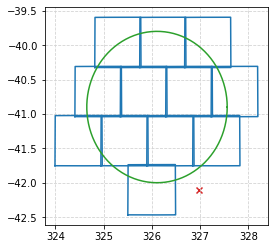

-52.973465 50550.816 (10000, 10000)


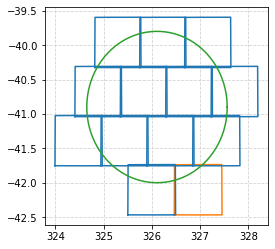

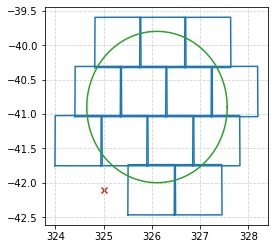

-77.341415 45739.22 (10000, 10000)


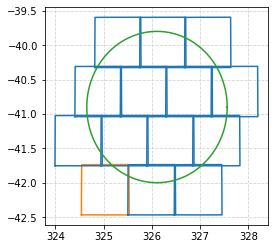

In [43]:
fov = 1.2
j0 = 0
END = False
direct = np.array([1,1]) # right, up
class BreakAllTheLoops(BaseException): pass
try:
    for j in range(5):
        direct[0] = 1 # right
        for k in range(5):
            if k==0 and j==0:
                ra = RA
                dec = DEC
            else:
                ra = ra_new
                dec = dec_new
            
            plt.figure(figsize=(4,4))
            for i in range(len(ra_save)):
                plt.plot(ra_save[i], dec_save[i], c='#1f77b4')
            plt.plot(x_arr, y_arr, c='#2ca02c')
            plt.grid(color='lightgray',linestyle='--')
            plt.scatter(ra,dec, marker='x', c='#d62728')
            plt.show()
            
            imgTable = svc_des_dr1.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
            sel = (imgTable['proctype'].astype(str)=='Stack') & (imgTable['prodtype'].astype(str)=='image') & (startswith(imgTable['obs_bandpass'].astype(str),'r'))

            row = imgTable[sel][0]
            url = row['access_url'] # get the download URL
            filename = download_file(url,cache=True,show_progress=False,timeout=120)
            hdu = fits.open(filename)[0]
            image = hdu.data
            print(image.min(),image.max(),image.shape)

            w = WCS(hdu.header)

            pix_x = list(range(hdu.data.shape[0]))
            pix_y = [0]*hdu.data.shape[0]
            ralist0 = np.zeros(hdu.data.shape[0])
            declist0 = np.zeros(hdu.data.shape[0])
            sky = w.pixel_to_world(pix_x,pix_y)
            ralist0 = sky.ra.deg
            declist0 = sky.dec.deg

            pix_x = [hdu.data.shape[0]]*hdu.data.shape[1]
            pix_y = list(range(hdu.data.shape[1]))
            ralist1 = np.zeros(hdu.data.shape[1])
            declist1 = np.zeros(hdu.data.shape[1])
            sky = w.pixel_to_world(pix_x,pix_y)
            ralist1 = sky.ra.deg
            declist1 = sky.dec.deg

            pix_x = list(range(hdu.data.shape[0]))
            pix_y = [hdu.data.shape[1]]*hdu.data.shape[0]
            ralist2 = np.zeros(hdu.data.shape[0])
            declist2 = np.zeros(hdu.data.shape[0])
            sky = w.pixel_to_world(pix_x,pix_y)
            ralist2 = sky.ra.deg[::-1]
            declist2 = sky.dec.deg[::-1]

            pix_x = [0]*hdu.data.shape[1]
            pix_y = list(range(hdu.data.shape[1]))
            ralist3 = np.zeros(hdu.data.shape[1])
            declist3 = np.zeros(hdu.data.shape[1])
            sky = w.pixel_to_world(pix_x,pix_y)
            ralist3 = sky.ra.deg[::-1]
            declist3 = sky.dec.deg[::-1]

            ralist = np.hstack((ralist0, ralist1, ralist2, ralist3))
            declist = np.hstack((declist0, declist1, declist2, declist3))

            plt.figure(figsize=(4,4))
            plt.plot(ralist, declist, c='#ff7f0e')
            for i in range(len(ra_save)):
                plt.plot(ra_save[i], dec_save[i], c='#1f77b4')
            plt.plot(x_arr, y_arr, c='#2ca02c')
            plt.grid(color='lightgray',linestyle='--')
            plt.show()

            ra_save.insert(len(ra_save)+1,ralist)
            dec_save.insert(len(dec_save)+1,declist)
            hdu_arr.insert(len(hdu_arr)+1,hdu)

            ra_cen = (w.pixel_to_world(0,0).ra.deg + w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).ra.deg) / 2
            dec_cen = (w.pixel_to_world(0,0).dec.deg + w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg) / 2

            if k==0 and j==0:
                # record the center of the image (ra=RA, dec=DEC)
                ra_0 = ra_cen
                dec_0 = dec_cen

            if k==0:
                # record the center of the raw
                ra_row_0 = ra_cen
                dec_row_0 = dec_cen
                if direct[1] == 1:
                    # check if the top of the image is larger than the edge of the ellepse
                    if w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg > max(y_arr):
                        direct[1] = -1 # turn to down
                        j0 = j  
                elif direct[1] == -1:
                    # check if the bottom of the image is smaller than the edge of the ellepse
                    if w.pixel_to_world(0,0).dec.deg < min(y_arr):
                        END = True

            if direct[0] == 1:
                # check if the right side of the image is larger than the edge of the ellepse
                row_top = w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg
                row_bottom = w.pixel_to_world(0,0).dec.deg
                edge_max = max(x_arr[np.where((y_arr<row_top)*(y_arr>row_bottom))])
                if w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).ra.deg > edge_max:
                    direct[0] = -1 # turn to left
                    ra_new = ra_row_0 - (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).ra.deg - w.pixel_to_world(0,0).ra.deg)
                    dec_new = dec_row_0
                else:
                    ra_new = ra_cen + (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).ra.deg - w.pixel_to_world(0,0).ra.deg)
                    dec_new = dec_cen

            elif direct[0] == -1:
                # check if the left side of the image is smaller than the edge of the ellepse
                row_top = w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg
                row_bottom = w.pixel_to_world(0,0).dec.deg
                edge_min = min(x_arr[np.where((y_arr<row_top)*(y_arr>row_bottom))])
                if w.pixel_to_world(0,0).ra.deg < edge_min:
                    if direct[1] == 1:
                        if j%2 == 0:
                            ra_new = ra_row_0 + (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg) * 0.5
                            dec_new = dec_row_0 + (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg)
                        else:
                            ra_new = ra_row_0 - (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg) * 0.5
                            dec_new = dec_row_0 + (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg) 
                        break
                    elif END==True:
                        raise BreakAllTheLoops()
                    elif j==j0:
                        ra_new = ra_0 + (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg) * 0.5
                        dec_new = dec_0 - (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg)
                        break
                    else: 
                        if (j-j0)%2 == 0:
                            ra_new = ra_row_0 + (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg) * 0.5
                            dec_new = dec_row_0 - (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg)
                        else:
                            ra_new = ra_row_0 - (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg) * 0.5
                            dec_new = dec_row_0 - (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).dec.deg - w.pixel_to_world(0,0).dec.deg) 
                        break
                else:
                    ra_new = ra_cen - (w.pixel_to_world(hdu.data.shape[0],hdu.data.shape[1]).ra.deg - w.pixel_to_world(0,0).ra.deg)
                    dec_new = dec_cen
except BreakAllTheLoops:
    pass

In [195]:
wcs_out, shape_out = find_optimal_celestial_wcs(hdu_arr, resolution=0.5 * units.arcsec)
array, footprint = reproject_and_coadd(hdu_arr,
                                       wcs_out, shape_out=shape_out,
                                       reproject_function=reproject_interp)

In [197]:
hdr = hdu_arr[0].header
del hdr[26:]
del hdr['CD1_1']
del hdr['CD1_2']
del hdr['CD2_1']
del hdr['CD2_2']
hdr['NAXIS1'] = shape_out[1]
hdr['NAXIS2'] = shape_out[0]
hdr['CRVAL1'] = wcs_out.to_header()['CRVAL1']
hdr['CRVAL2'] = wcs_out.to_header()['CRVAL2']
hdr['CRPIX1'] = wcs_out.to_header()['CRPIX1']
hdr['CRPIX2'] = wcs_out.to_header()['CRPIX2']
hdr.set('CDELT1', wcs_out.to_header()['CDELT1'])
hdr.set('CDELT2', wcs_out.to_header()['CDELT2'])
hdr.set('LONPOLE', wcs_out.to_header()['LONPOLE'])
hdr.set('LATPOLE', wcs_out.to_header()['LATPOLE'])

In [199]:
hdu_new = fits.PrimaryHDU([0])
hdul = fits.HDUList([hdu_new])
hdul[0].data = array
hdul[0].header = hdr
hdul.writeto('mask/'+FRB+'_rebin.fits')

In [227]:
for i in range(3):
    for j in range(4):
        print(i,j)
        if i == 2:
            break
    else:
        continue
    break

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0


In [229]:
class BreakAllTheLoops(BaseException): pass
try:
    for i in range(1,100):
        for j in range(1,100):
            raise BreakAllTheLoops()
except BreakAllTheLoops:
    pass